In [17]:
import requests
import pandas as pd

class StockData:
    """
    A class to fetch and process stock data from the EOD Historical Data API.
    """
    def __init__(self, csv_file_path: str, api_key: str) -> None:
        """
        Initialize the StockData object by loading ticker symbols and sectors from a CSV file.
        """
        self.ticker_names = pd.read_csv(csv_file_path)['Symbol'].tolist()
        self.ticker_sectors = pd.read_csv(csv_file_path)['GICS Sector'].tolist()
        self.ticker_info = dict(zip(self.ticker_names, self.ticker_sectors))
        self.api_key = api_key
        self.base_url = 'https://eodhd.com/api/eod'

    def _fetch_data(self, ticker: str, period: str, start: str, end: str):
        '''
        private method to fetch stock data for a single ticker symbol from the API.
        '''
        url = f"{self.base_url}/{ticker}.US?period={period}&from={start}&to={end}&api_token={self.api_key}&fmt=json"
        response = requests.get(url)
        if response.status_code == 200:
            return response.json()  
        else:
            print(f"Failed to fetch data for {ticker}: {response.status_code}")
            return None
        

    def fetch_stock(self, ticker: str, period: str, start: str, end: str) -> pd.DataFrame:
        """
        Fetches stock data for a single ticker and returns it as a pandas DataFrame.
        """
        print(f"fetch data for {ticker}...")
        result = self._fetch_data(ticker, period, start, end)
        df = pd.DataFrame(result)
        return df
    
    def fetch_stocks_by_sectors(self, sector: str, period: str, start: str, end: str) -> pd.DataFrame:
        """
        Fetches stock data for all tickers in a specific GICS sector and returns a merged DataFrame.
        """
        results = {}
        for ticker, s in self.ticker_info.items():
            if s == sector:
                results[ticker] = pd.DataFrame(self._fetch_data(ticker, period, start, end))

        all_data = self._process_merge_all_data(results)
        return all_data
    
    def fetch_all_stocks(self, period: str, start: str, end: str):
        '''
        Fetches stock data for all tickers and returns a merged DataFrame.
        '''
        results = {}
        for ticker in self.ticker_info.keys():
            results[ticker] = pd.DataFrame(self._fetch_data(ticker, period, start, end))

        all_data = self._process_merge_all_data(results)
        return all_data

    def _process_merge_all_data(self, dic:dict) -> pd.DataFrame:
        '''
        Private method to process and merge stock data from multiple tickers into a single DataFrame.
        '''
        all_data = []

        for name, df in dic.items():
            if df.empty:
                print(f"no data for {name}. skipping...")
                continue

            df['date'] = pd.to_datetime(df['date'])
            df['ticker'] = name
            all_data.append(df)

        full_data = pd.concat(all_data)

        full_data.set_index(['date', 'ticker'], inplace=True)

        return full_data


if __name__ == "__main__":  
    stock = StockData("C:/Users/92877/Downloads/sp_400_midcap1.csv", '662166cb8e3d13.57537943')
    #df = stock.fetch_stock(ticker = 'AA', period = 'd', start = '2010-01-01', end = '2010-07-01')
    #df = stock.fetch_stocks_by_sectors(sector='Materials', period = 'd', start = '2010-01-01', end = '2010-07-01')
    df = stock.fetch_all_stocks(period = 'd', start='2000-01-01', end='2024-08-30')
    print(df.head())
    print(df.shape)
        

                      open     high      low    close  adjusted_close   volume
date       ticker                                                             
2000-01-03 AA      83.0000  83.5624  80.3750  80.9375         70.4418  1291386
2000-01-04 AA      80.9375  81.8125  80.3125  81.3125         70.7682  1860008
2000-01-05 AA      81.3125  86.5000  81.0000  86.0000         74.8478  2598086
2000-01-06 AA      86.0000  86.3750  84.8125  84.8750         73.8687  3740907
2000-01-07 AA      84.8750  86.8750  84.5624  84.6250         73.6511  3774199
(1965552, 6)


In [19]:
df
df.to_csv("C:/Users/92877/Downloads/stock_data.csv", index=False)

In [23]:
# Reset the index to turn 'date' and 'ticker' into columns
df = df.reset_index()

# Now merge with sector_info
df_merged = pd.merge(df, sector_info[['ticker', 'GICS Sector']], on='ticker', how='left')

# Display the merged DataFrame to confirm 'date' is included
print("Merged DataFrame with 'date':")
print(df_merged.head())

Merged DataFrame with 'date':
        date ticker     open     high      low    close  adjusted_close  \
0 2000-01-03     AA  83.0000  83.5624  80.3750  80.9375         70.4418   
1 2000-01-04     AA  80.9375  81.8125  80.3125  81.3125         70.7682   
2 2000-01-05     AA  81.3125  86.5000  81.0000  86.0000         74.8478   
3 2000-01-06     AA  86.0000  86.3750  84.8125  84.8750         73.8687   
4 2000-01-07     AA  84.8750  86.8750  84.5624  84.6250         73.6511   

    volume GICS Sector  
0  1291386   Materials  
1  1860008   Materials  
2  2598086   Materials  
3  3740907   Materials  
4  3774199   Materials  


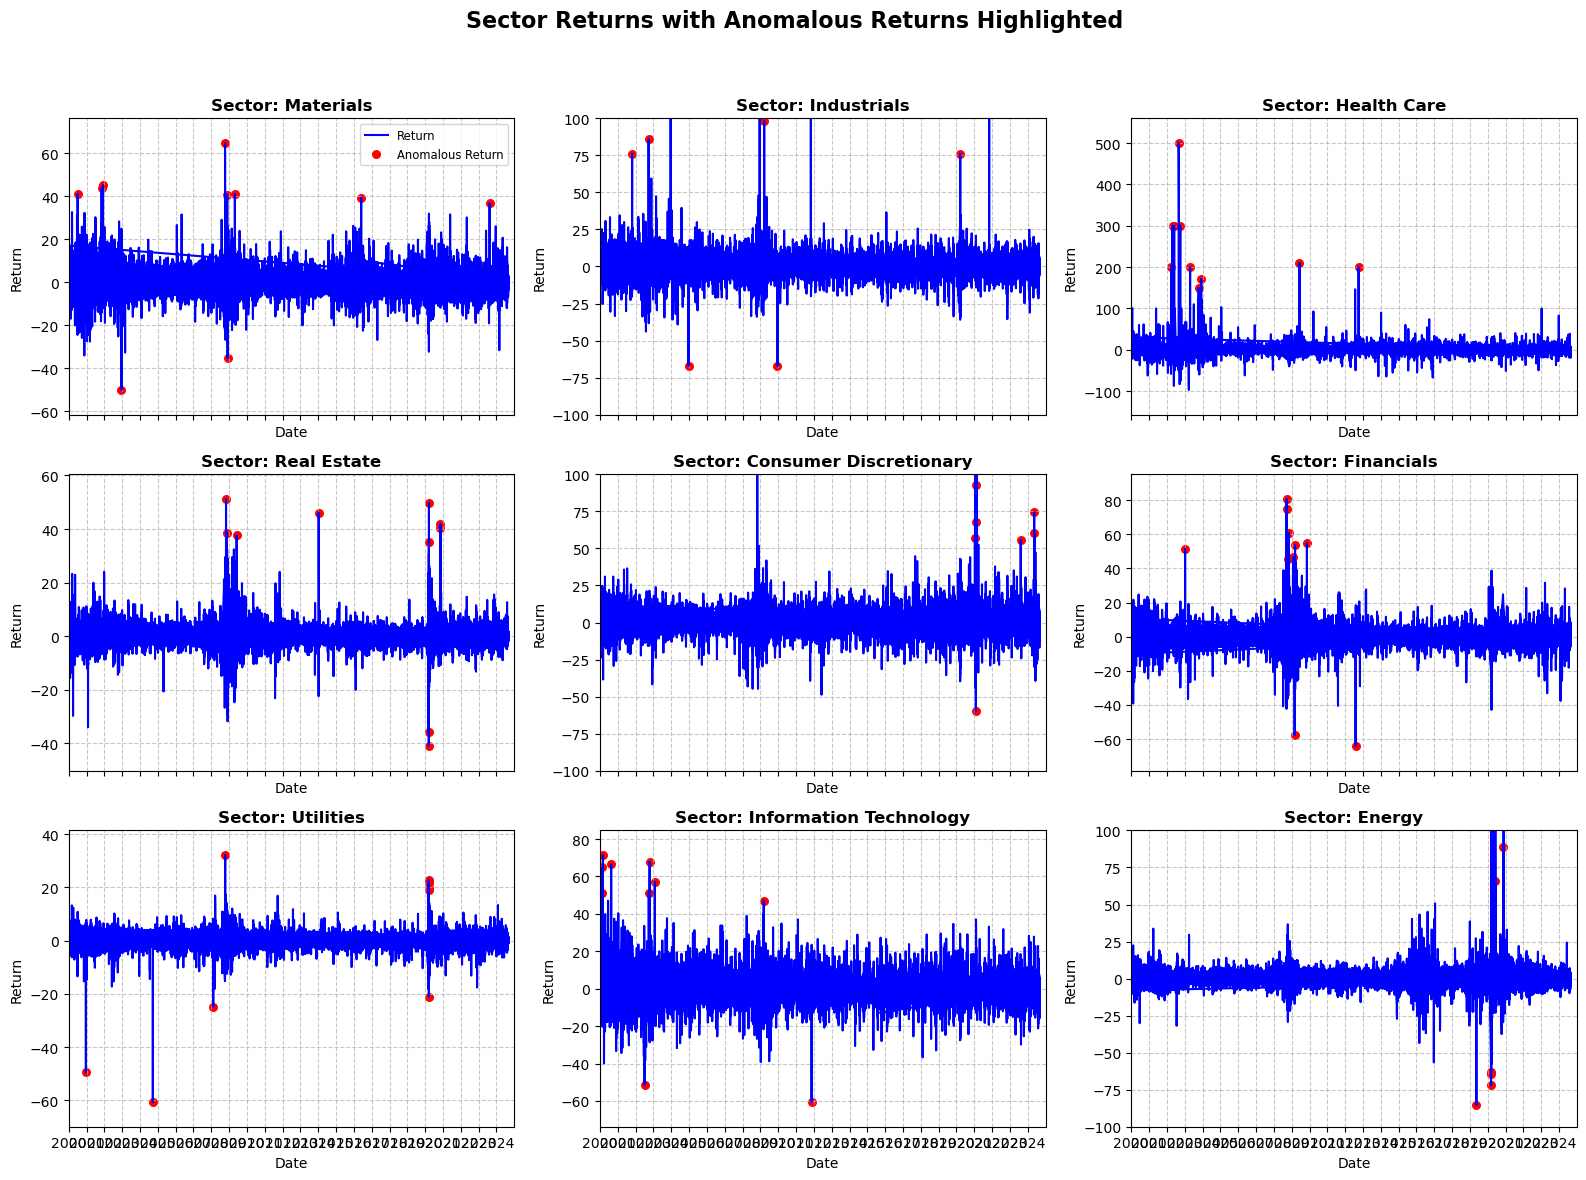

In [42]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure 'date' is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'], errors='coerce')  # Force any invalid dates to NaT
df_merged.dropna(subset=['date'], inplace=True)  # Remove rows with invalid dates

# Calculate daily returns (percentage change in adjusted_close price)
df_merged['return'] = df_merged.groupby('ticker')['adjusted_close'].pct_change() * 100
df_merged.dropna(subset=['return'], inplace=True)

# Define function to calculate Mahalanobis distance and detect anomalies
def calculate_anomalies(df_sector):
    mean_val = df_sector['return'].mean()
    var_val = df_sector['return'].var()  # Use variance for single variable covariance
    mean_array = np.array([mean_val])
    cov_inv = np.linalg.inv(np.array([[var_val]]))  # Inverse of variance is 1/variance
    distances = np.apply_along_axis(lambda x: mahalanobis(x, mean_array, cov_inv), 1, df_sector[['return']].values)
    df_sector['anomaly_score'] = distances
    return df_sector

# Prepare to collect anomalies for plotting
anomalies = []

# Calculate anomalies by sector
for sector in df_merged['GICS Sector'].unique():
    sector_df = df_merged[df_merged['GICS Sector'] == sector].copy()
    sector_df = calculate_anomalies(sector_df)
    top_anomalies = sector_df.nlargest(10, 'anomaly_score')  # Select top 10 anomalies for each sector
    anomalies.append((sector, top_anomalies))

# Set up the subplot grid (3x3 for 9 sectors)
sectors = df_merged['GICS Sector'].unique()
fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharex=True, sharey=False)  # 3x3 grid with independent y-axis limits
fig.suptitle("Sector Returns with Anomalous Returns Highlighted", fontsize=16, fontweight='bold')

# Define a maximum y-axis range to exclude extreme outliers for general sectors
max_y_limit = 100  # This limit can be adjusted based on your needs

# Plot each sector in its own subplot
for ax, (sector, top_anomalies) in zip(axes.flatten(), anomalies):
    sector_df = df_merged[df_merged['GICS Sector'] == sector]
    
    # Plot returns for the sector
    ax.plot(sector_df['date'], sector_df['return'], color='blue', label='Return')
    
    # Highlight anomalies with larger red markers
    ax.scatter(top_anomalies['date'], top_anomalies['return'], color='red', s=30, label='Anomalous Return')  # Increase marker size
    
    # Set title, labels, and grid
    ax.set_title(f"Sector: {sector}", fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Return')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Custom y-axis limit handling for Health Care sector
    if sector == "Health Care":
        sector_min, sector_max = sector_df['return'].min(), sector_df['return'].max()
        margin = (sector_max - sector_min) * 0.1  # 10% margin for Health Care
        ax.set_ylim(sector_min - margin, sector_max + margin)
    else:
        # Set y-axis limits, applying a cap for other sectors
        sector_min, sector_max = sector_df['return'].min(), sector_df['return'].max()
        if sector_max > max_y_limit:
            ax.set_ylim(-max_y_limit, max_y_limit)
        else:
            margin = (sector_max - sector_min) * 0.1  # 10% margin
            ax.set_ylim(sector_min - margin, sector_max + margin)
    
    # Customize x-axis date format to show only years from 2000 to 2024
    ax.set_xlim([pd.Timestamp('2000-01-01'), pd.Timestamp('2024-12-31')])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Show legend only on the first plot to save space
    if ax == axes[0, 0]:
        ax.legend(loc='best', fontsize='small')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()
